<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/stat547c_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import torch
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
sigma_z = 1.0  # Standard deviation for z
sigma_a = 1.0  # Standard deviation for observation noise

# Function to generate a random rotation matrix for a given angle
def rotation_matrix(theta):
    return torch.tensor([
        [torch.cos(theta), -torch.sin(theta)],
        [torch.sin(theta), torch.cos(theta)]
    ])

# Simulate the process
def determnistic(x,theta,z):
    # Step 1: Sample theta from Uniform(0, 2*pi)

    # Step 2: Create rotation matrix R
    R = rotation_matrix(theta)

    # Step 3: Sample z from Normal(0, sigma_z)

    # Step 4: Compute r = [1 0] * R * [z, 0]^T
    z_vec = torch.tensor([z, 0.0])  # [z, 0]^T
    r = torch.matmul(R, z_vec)[:2]  # Rotate and select the first two elements

    # Step 5: Compute I = exp(-|x - r|^2 / (2 * sigma_a^2))
    diff = x.reshape(-1,1) - r.reshape(1,-1)  # Difference vector
    I = torch.exp(-torch.sum(diff**2,1) / (2 * sigma_a**2))

    return I, theta, z

def joint(xs,mu_z=0, sigma_z=1):
    # Step 1: Sample theta from Uniform(0, 2*pi)
    theta = torch.distributions.Uniform(0, 2*math.pi).sample()
    z = torch.distributions.Normal(mu_z, sigma_z).sample()
    # I = torch.stack([determnistic(x,theta,z)[0] for x in xs])
    I = determnistic(xs,theta,z)[0]
    return I


In [51]:
n_discrete_points = 100
xs = torch.linspace(-3,3,n_discrete_points)

<Axes: >

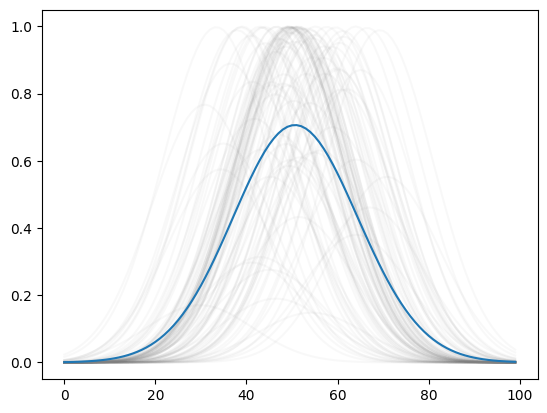

In [52]:
n_samples = 100
Is = torch.stack([joint(xs) for _ in range(n_samples)])

pd.DataFrame(Is.T.numpy()).plot(legend=False, alpha=0.05, color='gray')
pd.Series(Is.mean(0).numpy()).plot()



In [20]:
n_samples = 1000
Is = torch.stack([joint(xs,mu_z=3) for _ in range(n_samples)])
(Is.mean(0)*xs).mean()


tensor(-0.0006)

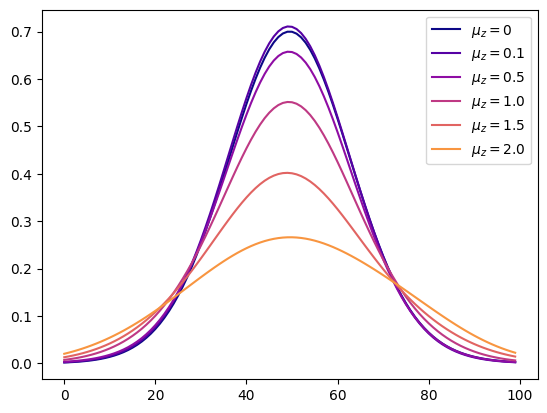

In [12]:
n_samples = 1000
mu_zs = [0,0.1,0.5,1.0,1.5,2.0]
color_in_steps = plt.cm.plasma(np.linspace(0,0.75, len(mu_zs)))
for idx, mu_z in enumerate(mu_zs):
  Is = torch.stack([joint(xs,mu_z=mu_z) for _ in range(n_samples)])
  pd.Series(Is.mean(0).numpy()).plot(label=rf'$\mu_z={mu_z}$', legend=~False, color=color_in_steps[idx])


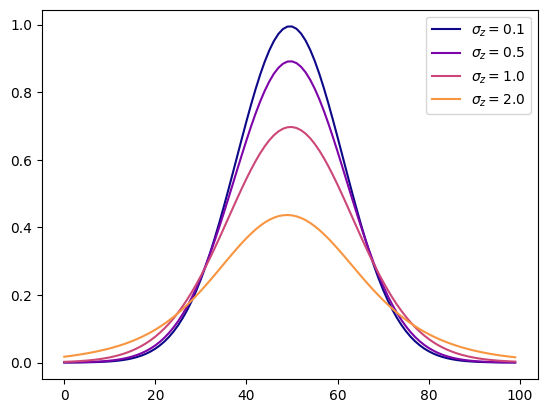

In [ ]:
n_samples = 1000
sigma_zs = [0.1,0.5,1.0,2.0]
color_in_steps = plt.cm.plasma(np.linspace(0,0.75, len(sigma_zs)))
for idx, sigma_z in enumerate(sigma_zs):
  Is = torch.stack([joint(xs,sigma_z=sigma_z) for _ in range(n_samples)])
  pd.Series(Is.mean(0).numpy()).plot(label=rf'$\sigma_z={sigma_z}$', legend=~False, color=color_in_steps[idx])


Compare $\mu_z$ and $\sigma_z$

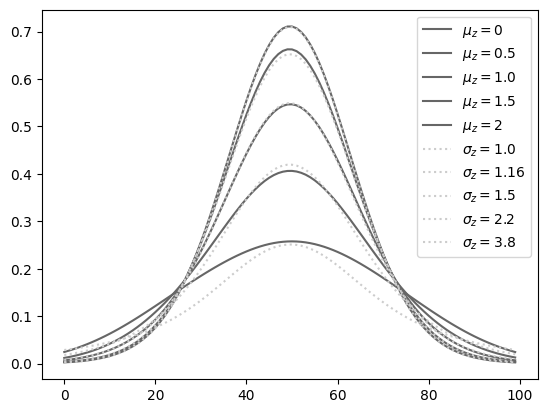

In [48]:
n_samples = 10000
mu_zs = [0,0.5,1.0,1.5,2]


color_in_steps = plt.cm.plasma(np.linspace(0,0.75, len(mu_zs)))
for idx, mu_z in enumerate(mu_zs):
  Is = torch.stack([joint(xs,mu_z=mu_z) for _ in range(n_samples)])
  pd.Series(Is.mean(0).numpy()).plot(label=rf'$\mu_z={mu_z}$', legend=True, color=plt.cm.gray(0.4))

sigma_zs = [1.0,1.16,1.5,2.2,3.8]

for idx, sigma_z in enumerate(sigma_zs):
  Is = torch.stack([joint(xs,sigma_z=sigma_z) for _ in range(n_samples)])
  pd.Series(Is.mean(0).numpy()).plot(label=rf'$\sigma_z={sigma_z}$', legend=True, color=plt.cm.gray(0.8), linestyle='dotted')


Gussian noise in measurement

In [53]:
sigma_y = 1
noise = torch.distributions.Normal(0, sigma_y).sample(Is.shape)

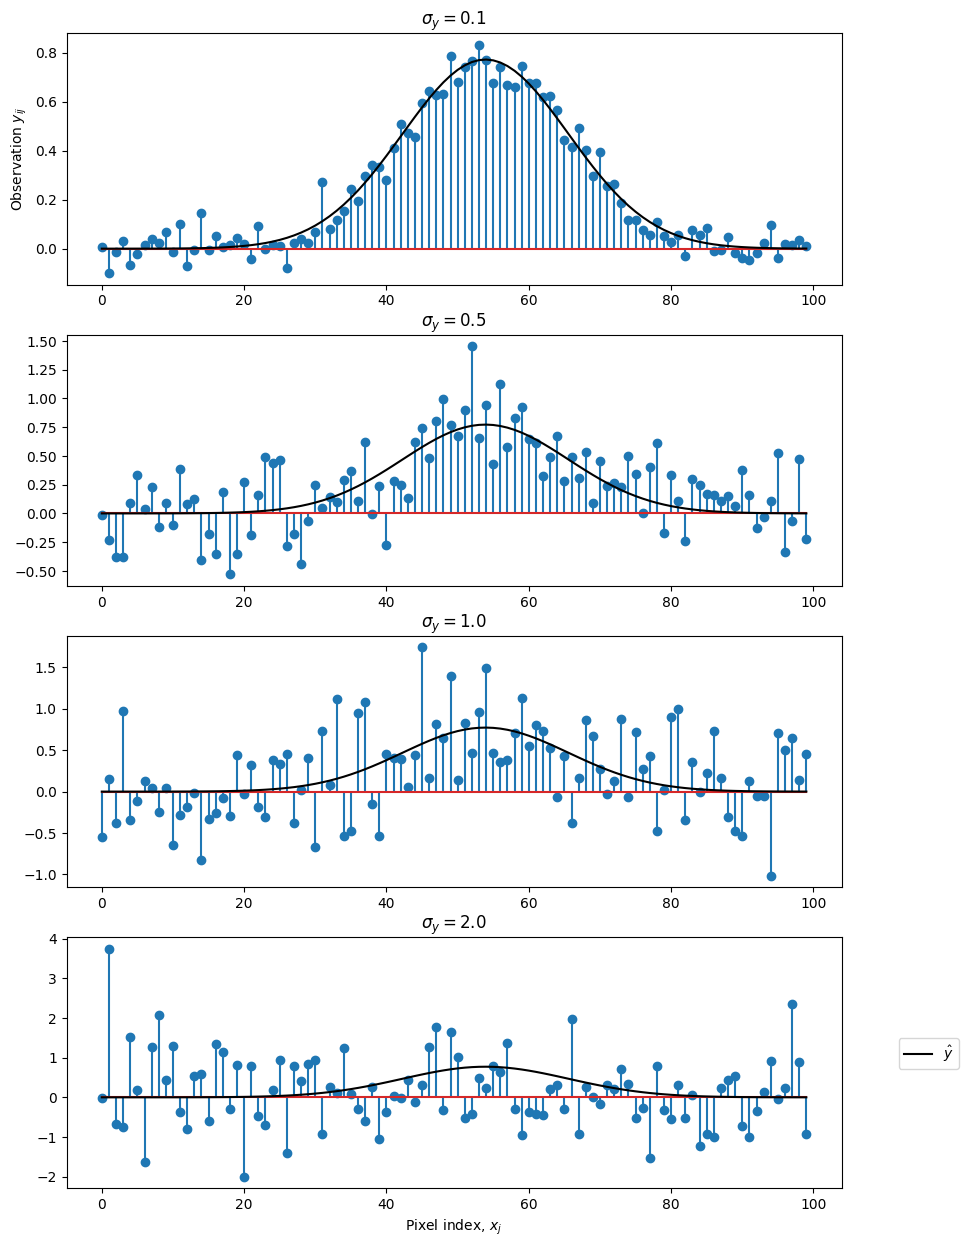

In [95]:
n_plt = 4
color_in_steps = plt.cm.gray(np.linspace(0.5,1, n_plt))
sigma_ys = [0.1,0.5,1.0,2.0]

fig, ax = plt.subplots(n_plt,figsize=(10,15))
for idx in range(n_plt):
  ax[idx].stem((Is[0]+sigma_ys[idx]*noise[idx]).T.numpy())
  ax[idx].set_title(rf'$\sigma_y={sigma_ys[idx]}$')

  if idx == 0:
    label = r'$\hat y$'
  else:
    label = None

  ax[idx].plot((Is[0]).T.numpy(), color='black', label=label)

ax[-1].set_xlabel(r'Pixel index, $x_j$')
ax[0].set_ylabel(r'Observation $y_{ij}$')

fig.legend(loc='center left', bbox_to_anchor=(0.95,0.2))


Uniqueness of estimate in finite sample (n_samples $< \infty$)

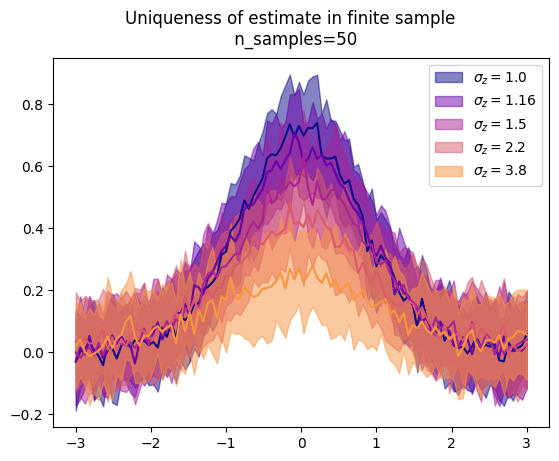

In [100]:
n_samples = 50
plt.suptitle(f'Uniqueness of estimate in finite sample \n n_samples={n_samples}')
sigma_y = 1

sigma_zs = [1.0,1.16,1.5,2.2,3.8]
color_in_steps = plt.cm.plasma(np.linspace(0,0.75, len(sigma_zs)))
finite_sample_trials = 30
for idx, sigma_z in enumerate(sigma_zs):
  Is = torch.empty(finite_sample_trials,n_samples,n_discrete_points)
  for finite_sample_idx in range(finite_sample_trials):
    noise = torch.distributions.Normal(0, sigma_y).sample(Is[finite_sample_idx].shape)
    Is[finite_sample_idx] = torch.stack([joint(xs,sigma_z=sigma_z) for _ in range(n_samples)]) + noise
  mean_finite_sample = Is.mean(1).numpy()
  mean = mean_finite_sample.mean(0)
  std = mean_finite_sample.std(0)
  plt.plot(xs, mean, color=color_in_steps[idx])
  plt.fill_between(x = xs, y1 = mean-std, y2 = mean+std, color = color_in_steps[idx], alpha=0.5, label=rf'$\sigma_z={sigma_z}$')
plt.legend()


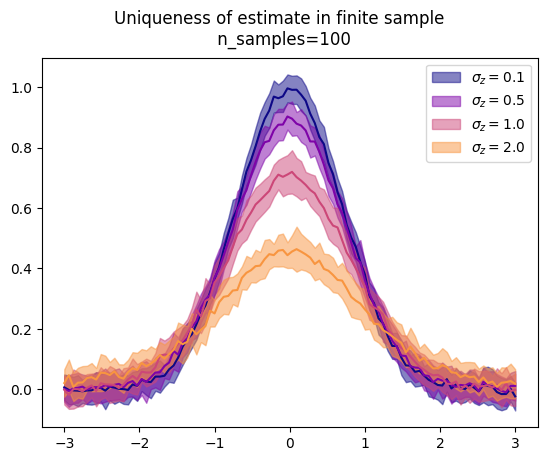

In [ ]:
n_samples = 100
plt.suptitle(f'Uniqueness of estimate in finite sample \n n_samples={n_samples}')


color_in_steps = plt.cm.plasma(np.linspace(0,0.75, len(sigma_zs)))
finite_sample_trials = 30
for idx, sigma_z in enumerate(sigma_zs):
  Is = torch.empty(finite_sample_trials,n_samples,n_discrete_points)
  for finite_sample_idx in range(finite_sample_trials):
    noise = torch.distributions.Normal(0, sigma_y).sample(Is[finite_sample_idx].shape)
    Is[finite_sample_idx] = torch.stack([joint(xs,sigma_z=sigma_z) for _ in range(n_samples)]) + noise
  mean_finite_sample = Is.mean(1).numpy()
  mean = mean_finite_sample.mean(0)
  std = mean_finite_sample.std(0)
  plt.plot(xs, mean, color=color_in_steps[idx])
  plt.fill_between(x = xs, y1 = mean-std, y2 = mean+std, color = color_in_steps[idx], alpha=0.5, label=rf'$\sigma_z={sigma_z}$')
plt.legend()


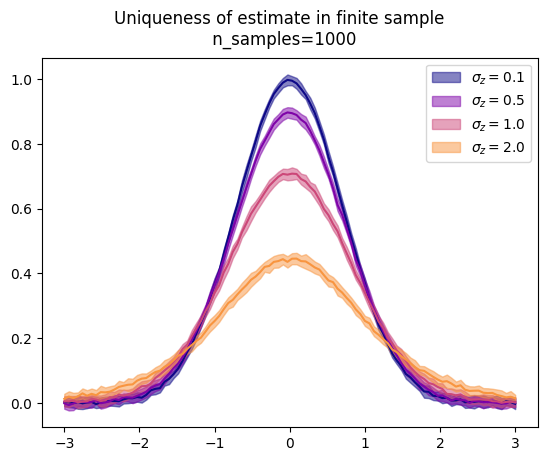

In [ ]:
n_samples = 1000
plt.suptitle(f'Uniqueness of estimate in finite sample \n n_samples={n_samples}')

color_in_steps = plt.cm.plasma(np.linspace(0,0.75, len(sigma_zs)))
finite_sample_trials = 30
for idx, sigma_z in enumerate(sigma_zs):
  Is = torch.empty(finite_sample_trials,n_samples,n_discrete_points)
  for finite_sample_idx in range(finite_sample_trials):
    noise = torch.distributions.Normal(0, sigma_y).sample(Is[finite_sample_idx].shape)
    Is[finite_sample_idx] = torch.stack([joint(xs,sigma_z=sigma_z) for _ in range(n_samples)]) + noise
  mean_finite_sample = Is.mean(1).numpy()
  mean = mean_finite_sample.mean(0)
  std = mean_finite_sample.std(0)
  plt.plot(xs, mean, color=color_in_steps[idx])
  plt.fill_between(x = xs, y1 = mean-std, y2 = mean+std, color = color_in_steps[idx], alpha=0.5, label=rf'$\sigma_z={sigma_z}$')
plt.legend()


# $\mu_z$

In [118]:
n_discrete_points = round(100*5/3)
xs = torch.linspace(-5,5,n_discrete_points)

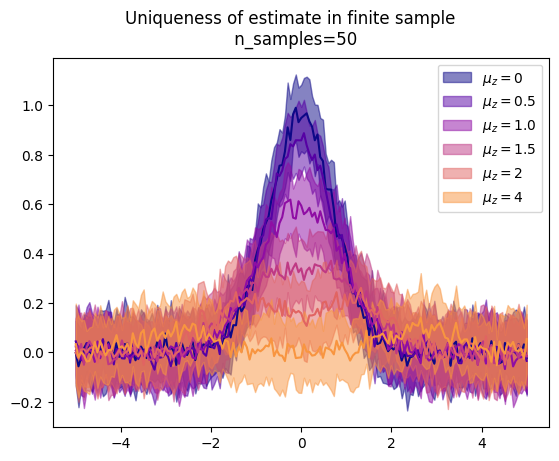

In [119]:
n_samples = 50
plt.suptitle(f'Uniqueness of estimate in finite sample \n n_samples={n_samples}')
sigma_y = 1

mu_zs = [0,0.5,1.0,1.5,2,4]
color_in_steps = plt.cm.plasma(np.linspace(0,0.75, len(mu_zs)))
finite_sample_trials = 30
for idx, mu_z in enumerate(mu_zs):
  Is = torch.empty(finite_sample_trials,n_samples,n_discrete_points)
  for finite_sample_idx in range(finite_sample_trials):
    noise = torch.distributions.Normal(0, sigma_y).sample(Is[finite_sample_idx].shape)
    Is[finite_sample_idx] = torch.stack([joint(xs,mu_z=mu_z, sigma_z=0.3) for _ in range(n_samples)]) + noise
  mean_finite_sample = Is.mean(1).numpy()
  mean = mean_finite_sample.mean(0)
  std = mean_finite_sample.std(0)
  plt.plot(xs, mean, color=color_in_steps[idx])
  plt.fill_between(x = xs, y1 = mean-std, y2 = mean+std, color = color_in_steps[idx], alpha=0.5, label=rf'$\mu_z={mu_z}$')
plt.legend()

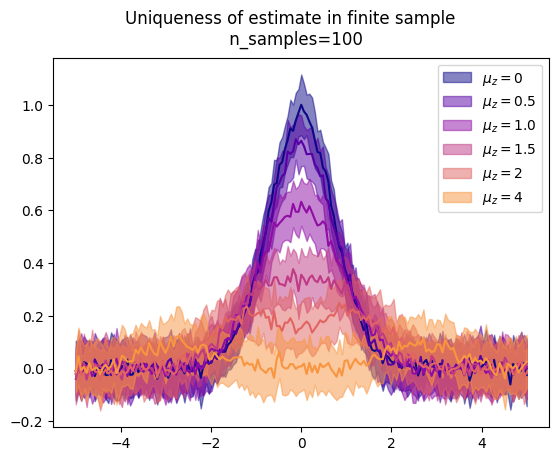

In [120]:
n_samples = 100
plt.suptitle(f'Uniqueness of estimate in finite sample \n n_samples={n_samples}')
sigma_y = 1

color_in_steps = plt.cm.plasma(np.linspace(0,0.75, len(mu_zs)))
finite_sample_trials = 30
for idx, mu_z in enumerate(mu_zs):
  Is = torch.empty(finite_sample_trials,n_samples,n_discrete_points)
  for finite_sample_idx in range(finite_sample_trials):
    noise = torch.distributions.Normal(0, sigma_y).sample(Is[finite_sample_idx].shape)
    Is[finite_sample_idx] = torch.stack([joint(xs,mu_z=mu_z,sigma_z=0.3) for _ in range(n_samples)]) + noise
  mean_finite_sample = Is.mean(1).numpy()
  mean = mean_finite_sample.mean(0)
  std = mean_finite_sample.std(0)
  plt.plot(xs, mean, color=color_in_steps[idx])
  plt.fill_between(x = xs, y1 = mean-std, y2 = mean+std, color = color_in_steps[idx], alpha=0.5, label=rf'$\mu_z={mu_z}$')
plt.legend()

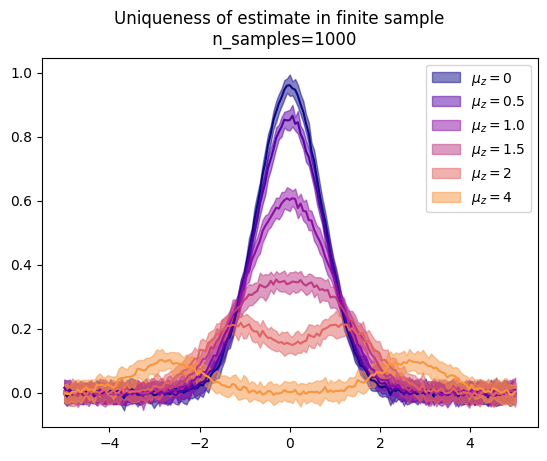

In [121]:
n_samples = 1000
plt.suptitle(f'Uniqueness of estimate in finite sample \n n_samples={n_samples}')
sigma_y = 1

color_in_steps = plt.cm.plasma(np.linspace(0,0.75, len(mu_zs)))
finite_sample_trials = 30
for idx, mu_z in enumerate(mu_zs):
  Is = torch.empty(finite_sample_trials,n_samples,n_discrete_points)
  for finite_sample_idx in range(finite_sample_trials):
    noise = torch.distributions.Normal(0, sigma_y).sample(Is[finite_sample_idx].shape)
    Is[finite_sample_idx] = torch.stack([joint(xs,mu_z=mu_z, sigma_z=0.3) for _ in range(n_samples)]) + noise
  mean_finite_sample = Is.mean(1).numpy()
  mean = mean_finite_sample.mean(0)
  std = mean_finite_sample.std(0)
  plt.plot(xs, mean, color=color_in_steps[idx])
  plt.fill_between(x = xs, y1 = mean-std, y2 = mean+std, color = color_in_steps[idx], alpha=0.5, label=rf'$\mu_z={mu_z}$')
plt.legend()